# Parallele Datenverarbeitung mit Dask

In diesem Beispiel sehen wir die Grundlagen, wie Python-Code mit Dask parallel (und potentiell verteilt) ausgeführt werden kann.

## Grundlagen

Als erstes schauen wir uns eine einfache Berechnung an, die eine zeitintensive Berechnung simuliert. Die `add`-Funktion addiert einfach zwei Werte, aber durch den `sleep(1)`-Befehl wartet die Funktion jedes Mal 1 Sekunde. Dies simuliert eine längere Berechnung: 

In [1]:
from time import sleep

def add(a, b):
    sleep(1)
    return a + b

Wir könnnen nun zwei unabhängige Berechnungen durchführen (`x` und `y`), und anschliessend eine Berechnung, die auf den 2 vorherigen aufbaut. Wir können also die Berechnung von `x` und `y` paralellisieren.

`%%time` erlaubt die Messung der Ausführungszeit.

In [2]:
%%time

x = add(1, 2)
y = add(3, 4)
z = add(x, y)

CPU times: user 0 ns, sys: 1.51 ms, total: 1.51 ms
Wall time: 3 s


Da die Berechnung in Serie durchgeführt wird, braucht der Prozess 3 Sekunden.

Mit `dask.delayed` können wir die Berechnung paralellisieren:

In [3]:
from dask import delayed

In [4]:
@delayed
def add2(a, b):
    sleep(1)
    return a + b

Die `add2`-Funktion benutzt den `@delayed`-Dekorator, der die Funktion in eine Dask-Funktion umwandelt.

Nun können wir die gleiche Berechnung wie vorhin durchführen:

In [5]:
%%time

x = add2(1, 2)
y = add2(3, 4)
z = add2(x, y)

CPU times: user 656 µs, sys: 123 µs, total: 779 µs
Wall time: 684 µs


Dabei geht die Berechnung sehr schnell. Zu schnell. Die Berechnung muss ja mindestens 2 Sekunden dauern...

Die Berechnung wurde erst geplant, und noch nicht ausgeführt:

In [6]:
z

Delayed('add2-7465f518-62ab-4ed7-b58c-2cbb724025f6')

Wir können den Ausführungsgraph anschauen.

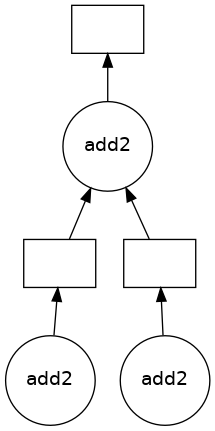

In [7]:
z.visualize()

Zur tatsächlichen Berechnung müssen wir die `compute()`-Funktion aufrufen:

In [8]:
%%time

z.compute()

CPU times: user 4.19 ms, sys: 4.19 ms, total: 8.38 ms
Wall time: 2.01 s


10

Und tatsächlich dauert die Berechnung nun 2 Sekunden.

## for-Schlaufe parallelisieren

In diesem Fall schauen wir und eine Schlaufe an, die ausschliesslich aus unabhängigen Berechnungen besteht, um anschliessend eine Summe zu berechnen. Eine klassische Map-Reduce-Anwendung.

Die Daten:

In [9]:
data = list(range(1, 10))
data

[1, 2, 3, 4, 5, 6, 7, 8, 9]

Die normale Berechnung in Serie mit Python dauert 9 Sekunden:

In [10]:
%%time

res = []
for n in data:
    a = add(n, 1)
    res.append(a)

total = sum(res)

CPU times: user 3.06 ms, sys: 0 ns, total: 3.06 ms
Wall time: 9.01 s


Mit Dask verwenden wir in der Schlaufe die dekorierte `add2` funktion.

Auch die `sum`-Funktion wird dekoriert. Diese Funktion existiert schon, deshalb können wir sie einfach mit `delayed(sum)` dekorieren, was eine neue Funktion zurückgibt.

Die anschliessende Ausführung dauert noch 2 Sekunden.

In [11]:
%%time

res = []
for n in data:
    a = add2(n, 1)
    res.append(a)

total = delayed(sum)(res)
total.compute()

CPU times: user 6.09 ms, sys: 6.33 ms, total: 12.4 ms
Wall time: 2.01 s


54

Auch hier können wir den Ausführungsgraph anschauen:

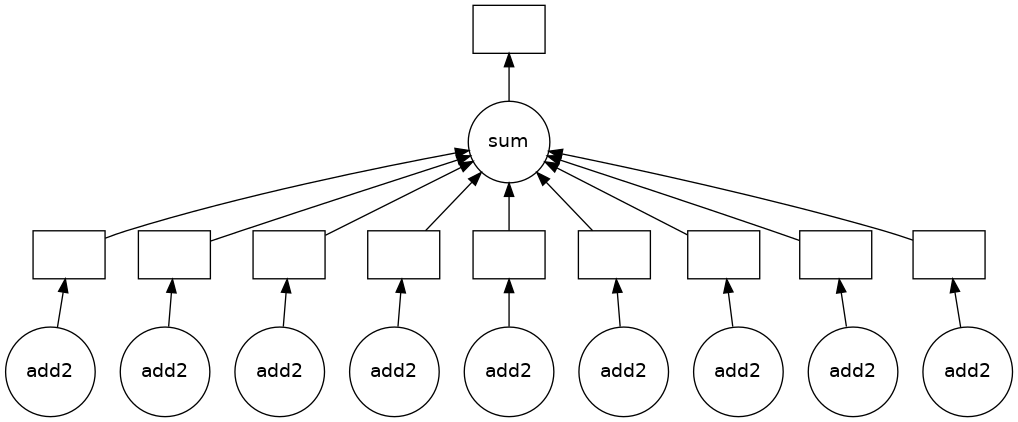

In [12]:
total.visualize()